## Number of fingers classification

In this notebook a small example where number of fingers shown on a hand is calculated. 

The main idea of this notebook is to show the potential of using pretrained models and how these models can be tuned to make another classification task then they where originally trained for.

In this case we use the VGG16 application in Keras and use the weights achived when trained on the Imagenet dataset. This training session takes 2-3 weeks on an average CPU.

Images was collected with a webacam and the aim of the images is to have enough images to make an application with a reasonoble accuracy.

In [17]:
#First load all packages
# import Augmentor

import numpy as np
import os
import tensorflow as tf
import os
#from PIL import Image
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from common import plot_confusion_matrix


ModuleNotFoundError: No module named 'common'

In [2]:
def load_images(folder,N):
    np.random.seed(9001)
    image_folders = os.listdir(folder)
    image_names = os.listdir(folder + image_folders[0])
    number_of_images = 0
    
    for label in image_folders:
        number_of_images += len(os.listdir(folder + label))
    data = np.zeros((N*len(image_folders), 224, 224, 3), dtype='float32')
    
    labels = []
    i = 0
    for label in image_folders:
        im_in_label = os.listdir(folder + label)
        for image_name in im_in_label[:N]:
            img = image.load_img(folder + label + '/' + image_name, target_size=(224, 224))
            img2 = np.array(img)
            img3 = img2 + int(np.random.random()*100-50)
            np.clip(img3, 0, 255,out=img3)
            img3 = img3/255.
            data[i, :, :, :] =img3
            labels.append(label)
            i+=1

    return data, labels

data, data_labels = load_images("./Images/",800)#
eval_data, eval_labels = load_images("./EvaluationImages/",200)

# Convert labels from strings to numbers
le = preprocessing.LabelEncoder()
le.fit(data_labels)
conv_labels = le.transform(data_labels) 
conv_labels_eval = le.transform(eval_labels)


# Delete images that are just zeros
data = data[0:len(conv_labels), :, :, :]
eval_data = eval_data[0:len(conv_labels_eval), :, :, :]
print('Data is initaly structured in blocks')
print(conv_labels)
# Shuffle the data
conv_labels, data = shuffle(conv_labels, data)
conv_labels_eval, eval_data = shuffle(conv_labels_eval, eval_data)
print('Data after shuffeling')
print(conv_labels)

Data is initaly structured in blocks
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

### Load a pretrained model
To save some time during the lab we load a pretrained model. The setupThat model setup is included in the bottom of this notebook to show the concept of adding layers to a previously trained model. 

This model adds a few layers on top of the vgg16 model included in Keras. The training cycle afteradding the extra layers took approx 1h.  

In [3]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 

In [4]:
n = 200
pred = loaded_model.predict(data[-n:], batch_size=16)

In [5]:
print('test')

test


In [6]:
compare_label = conv_labels[-n:]
pred_lab = np.argmax(pred, axis=1)
pred_lab==compare_label

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

In [13]:
pred_eval = loaded_model.predict(eval_data, batch_size=2)
pred_lab_eval = np.argmax(pred_eval, axis=1)
le.inverse_transform(pred_lab_eval)==le.inverse_transform(conv_labels_eval)

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True,  True,

corr 0.97860783 9.46258e-06
corr 0.4964363 0.00017864675
not_corr 0.61606693 0.0014105698


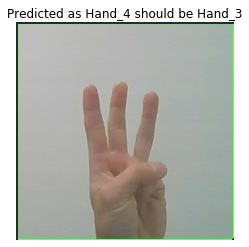

corr 0.92823416 0.0007985408
corr 0.8861781 1.9079014e-05
corr 0.62467474 0.002734071
corr 0.9449917 0.00057960226
corr 0.97599864 0.00015282808
corr 0.7763972 2.438447e-05
corr 0.80846435 0.0001711527
corr 0.84159505 1.1206084e-06
corr 0.6612767 0.0019570952
corr 0.617429 0.0018026066
corr 0.89603186 4.835988e-05
corr 0.85390913 2.1680387e-05
corr 0.54081416 0.0006139575
corr 0.9827939 0.00018769054
corr 0.66041744 4.4938042e-05
not_corr 0.6281616 0.0083076665


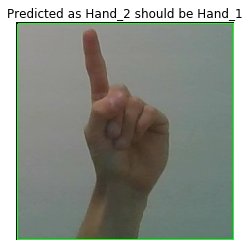

corr 0.54912066 0.0017247286
not_corr 0.7981943 1.94884e-05


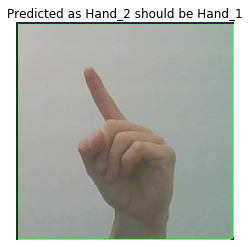

corr 0.8115688 0.0013185542
corr 0.77794284 0.0018914865
corr 0.7895762 0.00025093323
corr 0.5057894 0.00025590818
corr 0.8280546 0.0039732805
corr 0.97502637 0.00020593192
corr 0.5712837 0.0042467276
not_corr 0.570687 0.00026853156


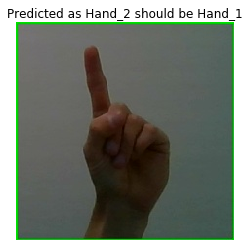

not_corr 0.53969985 0.00042731897


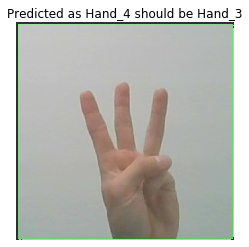

corr 0.7351787 0.0028905033
corr 0.92249876 0.0006461891
corr 0.9509556 1.3803312e-05
corr 0.9322087 1.5694428e-05
corr 0.8275355 5.911366e-05
corr 0.6649077 0.016803356
not_corr 0.67264843 0.0009349104


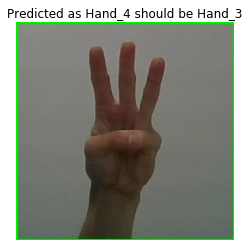

corr 0.8447225 8.0067175e-06
not_corr 0.6525205 3.7425845e-05


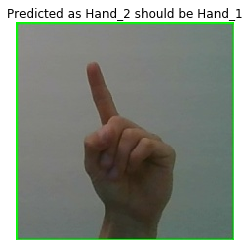

not_corr 0.6311813 0.00047354127


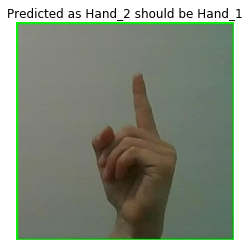

corr 0.78970134 0.010570526
corr 0.4582926 0.002153552
corr 0.9711934 4.4671375e-05
corr 0.97409534 8.9226e-07
corr 0.93517923 6.890911e-05
corr 0.65235746 0.0011810362
corr 0.94117415 0.00035678898
corr 0.94896644 0.00016431873
corr 0.94067913 1.6459368e-05
corr 0.7076201 0.0008687004
corr 0.8730838 8.659386e-06
corr 0.9053059 6.1253835e-05
corr 0.95604885 0.00024055493
corr 0.85423464 0.005590647
corr 0.9186196 2.9782166e-05
corr 0.8316598 9.5042305e-05
corr 0.82319933 0.009329307
corr 0.69333917 0.0013273306
corr 0.79944474 0.010408042
corr 0.9637202 0.00014653763
corr 0.97359633 6.7578867e-07
corr 0.99335206 6.8528075e-06
not_corr 0.62165 0.0007330602


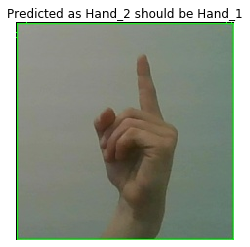

not_corr 0.66742533 0.00016425387


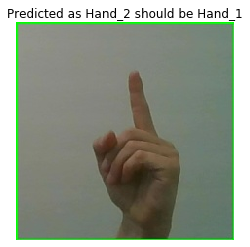

corr 0.90999806 2.7454003e-05
corr 0.90990824 0.00067493774
corr 0.8142404 0.00014424436
corr 0.7466289 0.00034009697
corr 0.7621058 0.007676334
corr 0.7418485 0.0012373861
corr 0.8283651 0.012988621
corr 0.9687769 7.9651334e-05
corr 0.98120534 7.519647e-05
corr 0.9724907 8.2049126e-05
corr 0.4949735 0.0010218641
corr 0.81172717 0.0044333315
corr 0.6990914 2.209228e-05
corr 0.98416674 7.19628e-05
corr 0.9806082 9.4644194e-05
corr 0.92421246 0.007870027
corr 0.72897553 0.0011630002
not_corr 0.5886705 0.0006508669


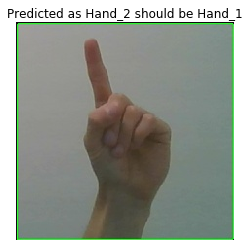

corr 0.9945208 1.6644854e-05
corr 0.9871437 5.384825e-06
corr 0.49133086 0.00072583737
corr 0.97463495 0.000108402855
corr 0.65795326 7.3778e-06
corr 0.61862415 0.00028548474
corr 0.84925646 0.0039436053
corr 0.95545375 1.13628e-07
corr 0.98874414 8.6966875e-06
corr 0.9465799 3.873066e-05
corr 0.7779322 0.0054465993
corr 0.8635726 8.218256e-06
corr 0.9609477 5.9007707e-06
corr 0.737882 0.004160748
corr 0.9115964 2.222703e-06
corr 0.9152998 0.0002553419
corr 0.9308509 1.7165148e-05
corr 0.96447176 6.514948e-05
corr 0.7110177 0.013656409
corr 0.95381075 3.1681031e-06
corr 0.93427736 2.258605e-06
corr 0.97101676 0.00010999807
corr 0.92826116 2.1029207e-05
corr 0.9647777 4.0186687e-06
corr 0.87051547 2.561332e-07
corr 0.9748064 2.493488e-05
corr 0.9607592 0.0003991894
not_corr 0.7514467 0.0004567325


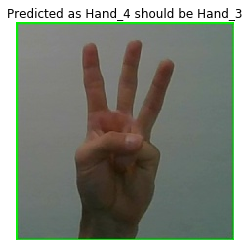

not_corr 0.48411408 0.007844178


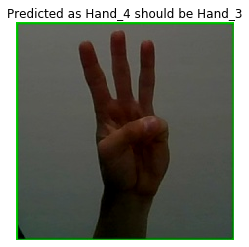

corr 0.95638895 3.4144636e-05
corr 0.91499686 1.099461e-06
corr 0.7605058 0.019173346
corr 0.47156602 0.033813402
corr 0.97978413 1.3449667e-06
corr 0.56838334 0.0034655158
corr 0.9792966 0.000100303056
not_corr 0.6915177 0.0006811055


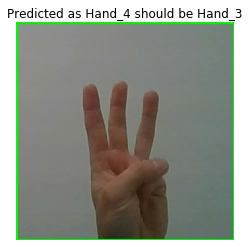

corr 0.99561536 8.3103345e-07
not_corr 0.8626705 6.6178e-05


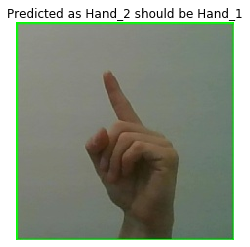

not_corr 0.6592812 0.0006328263


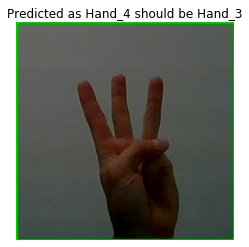

corr 0.70385385 0.00030615256
not_corr 0.62593764 1.0912032e-05


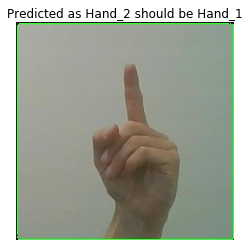

corr 0.7445866 0.005803327
corr 0.91558826 1.2314072e-05
corr 0.9287042 2.4473566e-05
corr 0.9303488 9.823742e-05
corr 0.96403384 0.00014690118
corr 0.9892938 3.9669892e-05
corr 0.5635143 0.0002695603
corr 0.7316296 5.9594447e-07
corr 0.94760907 3.365114e-07
corr 0.9641404 7.9323676e-05
corr 0.91143066 0.00048597323
corr 0.98984337 7.4042066e-07
corr 0.6595292 0.027682198
not_corr 0.52741563 0.0010754984


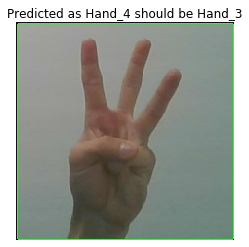

corr 0.93624914 0.0004504525
corr 0.96805567 0.00021817465
corr 0.9332916 2.2080309e-05
corr 0.7743216 0.007747633
not_corr 0.48778877 0.0010566651


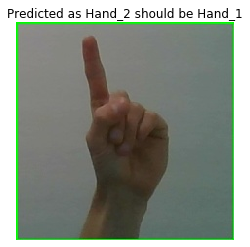

corr 0.9100239 1.4449646e-05
corr 0.9780734 9.065009e-05
corr 0.6335911 1.5938498e-05
corr 0.8957955 0.0069893617
corr 0.9412104 2.8675002e-05
corr 0.69697213 0.00091909594
corr 0.8331623 0.0069198236
corr 0.9826231 4.7996116e-05
corr 0.67762864 0.001308262
corr 0.73598504 0.0012755097
not_corr 0.5224817 3.5451932e-05


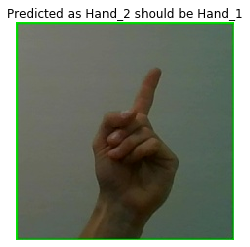

not_corr 0.8263424 4.6852216e-05


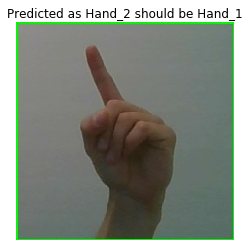

not_corr 0.5918119 0.001010181


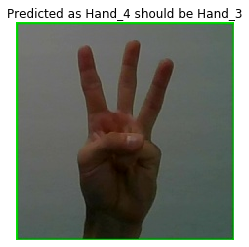

corr 0.642951 0.00716869
corr 0.9721458 6.375122e-05
corr 0.9521421 0.0003101489
corr 0.9562009 1.3998262e-05
not_corr 0.7266925 0.00024124296


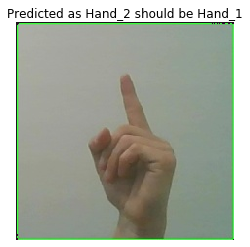

corr 0.9469492 1.4764569e-05
not_corr 0.5336008 0.00026216175


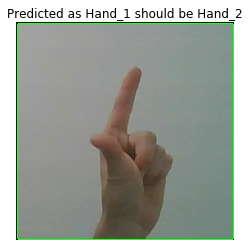

corr 0.72214985 4.4673834e-06
corr 0.87380284 0.0022355444
corr 0.62248254 0.0012153636
corr 0.9416229 2.434031e-06
corr 0.98219025 8.6803055e-05
corr 0.84256667 4.355515e-05
corr 0.9544575 1.1924637e-05
corr 0.51050496 0.000688186
corr 0.7110373 7.1266068e-06
corr 0.95151776 3.8501512e-05
corr 0.6892069 2.1140078e-05
corr 0.6575722 0.0035018628
corr 0.95952785 0.00034789543
corr 0.9846186 6.360656e-05
corr 0.95723474 0.00019665582
corr 0.9937855 1.0742866e-05
corr 0.8440273 5.2243562e-05
corr 0.92340136 7.27047e-05
not_corr 0.7294309 0.00030086483


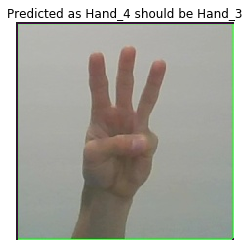

corr 0.89908385 9.81817e-07
corr 0.56579906 0.00076351914
corr 0.8398524 0.0006073511
corr 0.937582 1.3891155e-05
corr 0.85587436 0.016002702
not_corr 0.6127542 0.0010052321


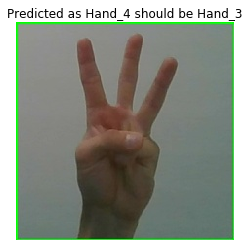

not_corr 0.6235749 0.0018630724


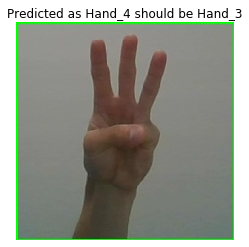

corr 0.9945368 6.802432e-07
corr 0.7054133 0.011983828
corr 0.95454353 3.0897183e-05
corr 0.48194957 1.8152652e-05
corr 0.9729135 0.00012352462
corr 0.7404518 0.00048311197
corr 0.81520987 4.0254374e-05
corr 0.99253994 1.3126157e-05
not_corr 0.58631885 0.00040074534


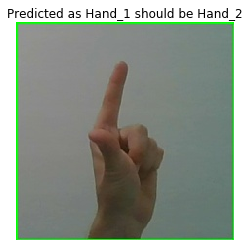

corr 0.5186209 0.00021076984
corr 0.94452137 1.51672775e-05
corr 0.70219976 0.002908973
corr 0.81513506 0.0036125614
corr 0.72127706 0.034703143
corr 0.98625165 6.115557e-05
corr 0.9325052 2.0968791e-05
not_corr 0.46446744 0.0009974972


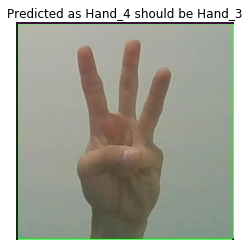

corr 0.9448544 8.441315e-05
corr 0.9384619 2.237713e-05
corr 0.9000165 2.871101e-06
corr 0.964209 1.0164906e-07
not_corr 0.6045149 0.00012320606


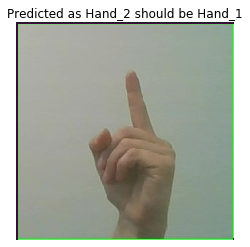

corr 0.7187632 0.00029417756
corr 0.9490771 1.1712642e-06
corr 0.8844738 8.177108e-06
corr 0.9774849 0.00023183745
corr 0.9273237 6.1681612e-06
corr 0.72455525 0.00016689204
corr 0.63116616 0.0028514578
corr 0.93260723 3.3456647e-05
not_corr 0.5659948 9.457639e-06


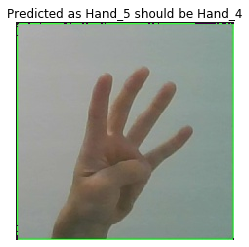

corr 0.9411662 1.0257053e-05
corr 0.7912221 0.00021187733
not_corr 0.5465739 0.00049001124


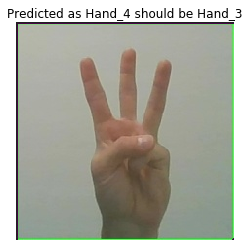

corr 0.94352055 4.8164995e-05
corr 0.9897121 1.2401316e-05
corr 0.7683669 0.0006412529
corr 0.9825776 0.00010677706
corr 0.96634275 1.0401181e-06
not_corr 0.68525666 0.00032435698


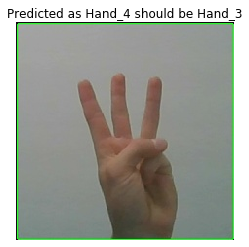

corr 0.84357774 8.317991e-05
corr 0.98804575 3.1320753e-05
corr 0.6586953 0.0003236376
corr 0.9375924 1.1924297e-07
corr 0.84371424 3.865447e-05
corr 0.9936667 2.3700204e-06
corr 0.9937655 6.7288065e-06
corr 0.86645544 0.0015734079
corr 0.96407974 2.557282e-05
corr 0.98183066 8.0627804e-05
corr 0.96512514 0.00016832062
corr 0.96855944 1.2003012e-05
corr 0.7088977 0.0021656808
corr 0.9420103 8.706501e-06
not_corr 0.6057162 0.00018364788


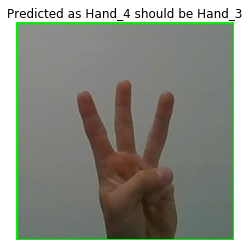

corr 0.8215932 0.00723342
corr 0.9537267 0.00018729614
not_corr 0.58093655 0.000715513


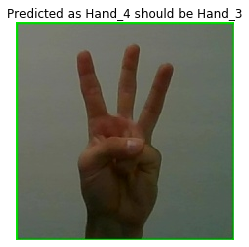

corr 0.6533534 0.0025501144
not_corr 0.563588 0.00021377938


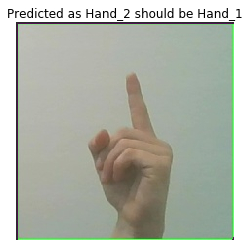

corr 0.69774497 0.0070562507
corr 0.55636305 0.0007685219
corr 0.7768436 0.00026312564
corr 0.95613134 0.000640557
corr 0.98291093 7.0615024e-05
corr 0.9838981 3.6682363e-07
corr 0.7362559 0.0025657779
corr 0.6768906 0.0006208805
not_corr 0.8604358 7.422896e-05


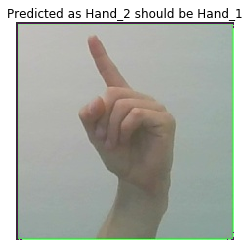

corr 0.77106214 4.3048403e-06
corr 0.9452286 0.0001203971
corr 0.8498842 2.9046001e-05
not_corr 0.67902863 5.2999476e-05


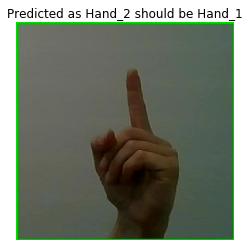

corr 0.84495664 0.0016242245
corr 0.815982 0.003588183
corr 0.8861126 0.0016220472
corr 0.5926139 2.6123133e-05
corr 0.92334807 1.8121005e-05
corr 0.95509183 0.00027415308
corr 0.9647261 0.00018756017
corr 0.97205263 3.2334443e-05
corr 0.9775029 0.00017982388
corr 0.67869043 0.008512599
corr 0.88772625 0.006272898
corr 0.830588 0.0038232831
corr 0.7684158 0.00032410724
corr 0.98664397 1.9083445e-06
corr 0.78096074 0.009984868
corr 0.6838566 2.5111556e-05
corr 0.94545084 2.0881673e-06
corr 0.58527 0.0029129721
corr 0.98231953 9.031893e-05
corr 0.8553379 0.013137945
corr 0.8531079 5.29586e-05
corr 0.8603625 9.75082e-05
corr 0.7306198 0.009301459
corr 0.8396032 1.45423555e-05
corr 0.6384234 0.0014743005
corr 0.52627176 0.0024296818
not_corr 0.5331095 1.8775556e-05


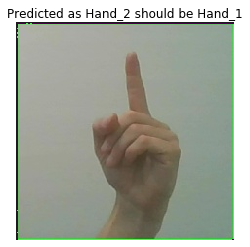

corr 0.8565028 1.1198511e-05
corr 0.98475164 5.9540693e-05
0.865979381443299


In [14]:
correct = 0
incorrect = 0
for i in range(len(pred_lab_eval)):
    if pred_lab_eval[i]==conv_labels_eval[i]:
        print('corr',np.max(pred_eval[i]), np.min(pred_eval[i]))
        correct += 1
    else:
        incorrect += 1
        print('not_corr',np.max(pred_eval[i]), np.min(pred_eval[i]))
        #print()
        plt.imshow(eval_data[i])
        plt.title('Predicted as ' + le.inverse_transform([pred_lab_eval[i]])[0]+' should be ' + le.inverse_transform([conv_labels_eval[i]])[0] )
        plt.axis('off')
        plt.show()
print(correct/(correct+incorrect))

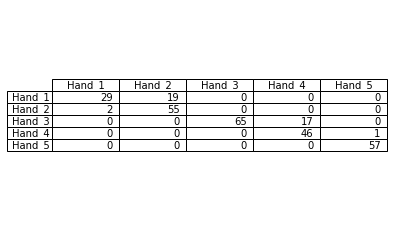

In [44]:
conf_mat = confusion_matrix(conv_labels_eval, np.argmax(pred_eval, axis=1))
plt.table(cellText=conf_mat,
                      rowLabels=le.classes_,
                      #rowColours=colors,
                      colLabels=le.classes_,
                      loc='center')
plt.axis('off')
plt.show()

In [16]:
class_names= np.unique(conv_labels_eval)
plot_confusion_matrix.plot_confusion_matrix(conv_labels_eval, np.argmax(pred_eval, axis=1), classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()

NameError: name 'plot_confusion_matrix' is not defined

In [28]:
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import LogNorm
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fig_size=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    else:
        cm = cm
    

    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    im = ax.imshow(cm,norm=LogNorm(), cmap=cmap,
                interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ylim=ax.get_ylim()
    ax.set(
        ylim=ylim,
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, 
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [39]:
# serialize model to JSON
model_json = loaded_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [41]:
loaded_pred_eval = loaded_model.predict(eval_data, batch_size=2)
loaded_pred_lab_eval = np.argmax(loaded_pred_eval, axis=1)
print(conv_labels_eval)

[4 2 2 1 3 2 1 4 0 0 0 2 0 3 3 2 1 0 0 2 0 2 4 3 0 2 4 2 0 2 2 1 1 3 3 2 2
 3 0 0 2 2 1 4 3 2 4 1 3 2 3 1 4 2 3 0 2 2 2 4 4 4 0 0 3 4 0 0 2 3 2 1 4 1
 2 2 3 1 1 2 2 0 4 4 0 4 0 0 2 4 4 3 2 0 1 2 3 1 3 1 2 4 4 4 1 3 4 1 1 2 2
 3 4 2 2 4 2 4 2 4 0 2 0 0 2 3 1 1 1 4 1 4 4 1 4 4 2 2 1 1 3 2 0 1 4 3 2 3
 1 2 4 1 1 0 0 2 2 1 4 1 0 1 1 4 2 2 1 1 3 3 2 4 1 0 2 1 1 4 4 3 1 2 3 0 4
 1 2 2 2 4 2 3 3 1 0 3 4 1 0 1 2 2 2 4 3 2 1 1 3 4 0 0 3 3 1 0 0 2 3 3 1 1
 2 1 4 3 4 3 2 0 4 0 4 3 4 4 2 1 4 4 3 2 3 2 2 4 2 3 0 2 2 3 1 4 0 1 2 0 4
 1 3 0 2 2 2 3 1 1 4 1 1 2 2 2 0 4 2 3 0 2 4 2 3 0 2 0 2 2 0 0 4]


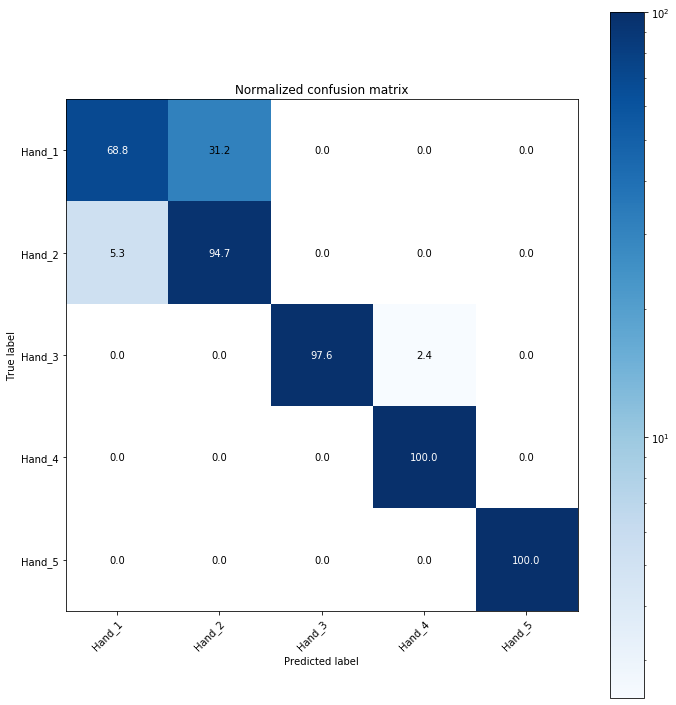

In [42]:
class_names= np.unique(conv_labels_eval)
plot_confusion_matrix(conv_labels_eval, np.argmax(loaded_pred_eval, axis=1), classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()

In [39]:
# # initialize the number of epochs and batch size
EPOCHS = 4
BS = 16
 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")

loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"]) 
# train the network 
# Note that 10 epochs takes approx 1,5h....
                      


In [40]:
H = loaded_model.fit_generator(aug.flow(data, conv_labels, batch_size=BS),
                               validation_data=(eval_data , conv_labels_eval), 
                               steps_per_epoch=len(data) // BS,
                               epochs=EPOCHS)

Epoch 1/4
53/53 [==============================] - 626s 12s/step - loss: 0.4300 - accuracy: 0.8529 - val_loss: 0.2003 - val_accuracy: 0.9485
Epoch 2/4
53/53 [==============================] - 601s 11s/step - loss: 0.3765 - accuracy: 0.8756 - val_loss: 0.4387 - val_accuracy: 0.8316
Epoch 3/4
53/53 [==============================] - 607s 11s/step - loss: 0.3401 - accuracy: 0.8720 - val_loss: 0.3950 - val_accuracy: 0.8660
Epoch 4/4
53/53 [==============================] - 601s 11s/step - loss: 0.3115 - accuracy: 0.8876 - val_loss: 0.1897 - val_accuracy: 0.9313


In [33]:
history = loaded_model.fit(data, conv_labels, validation_data=(eval_data,conv_labels_eval), epochs=15, batch_size=32)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

# Building on top of VGG16 model
In this notebook we have loaded a previously trained model. The procedure of loading a trained model and adding layers to that model is described in the cell below.

Working with complex deep learning classification tasks of images without using a previusly trained model is a good way of wasting time. Training the VGG16 model takes a few weeks on an ordinary computer while loading it takes a few seconds.  

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
from tensorflow.keras.layers import GlobalAveragePooling2D
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#vgg16 = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
#Lock the VGG model parameters
for layer in vgg16.layers:
    layer.trainable = False

headModel = vgg16.output
headModel = GlobalAveragePooling2D(name="GlobalMaxPooling", data_format='channels_last')(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(5, activation="softmax")(headModel)#

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=vgg16.input, outputs=headModel)
model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
###
###

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# # initialize the number of epochs and batch size
EPOCHS = 10
BS = 16
 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")
 
# train the network 
# Note that 10 epochs takes approx 1,5h....
H = model.fit_generator(aug.flow(data, conv_labels, batch_size=BS),
                        validation_data=(eval_data , conv_labels_eval), steps_per_epoch=len(data) // BS,
                        epochs=EPOCHS)
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(H.history['accuracy'], label='train')
ax[0].plot(H.history['val_accuracy'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(H.history['loss'], label='train')
ax[1].plot(H.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()